#EECS 504 PS8: Representation learning

__Please provide the following information__
(e.g. Andrew Owens, ahowens):

Rucha Apte, ruchaa

__Important__: after you download the .ipynb file, please name it as __\<your_uniquename\>_\<your_umid\>.ipynb__ before you submit it to canvas. Example: adam_01101100.ipynb.


# Starting

Run the following code to import the modules you'll need. After your finish the assignment, remember to run all cells and save the note book to your local machine as a .ipynb file for Canvas submission.

In [1]:
!pip install torchsummary
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import itertools

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision
from torchvision import datasets, models, transforms

from torchsummary import summary
from tqdm import tqdm_notebook

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only. If you want to enable GPU, please to go Edit > Notebook Settings > Hardware Accelerator and select GPU.")

np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

PyTorch Version:  1.4.0
Torchvision Version:  0.5.0
Using the GPU!


# Pset 8. Self-supervised learning

In this problem, we are going to implement two representation learning methods: an autoencoder and a recent constrastive learning method. 
We'll then test the features that were learned by these models on a "downstream" recognition task, using the STL-10 dataset.


# Downloading the dataset.

We use PyTorch built-in class to download  the STL-10 (http://ai.stanford.edu/~acoates/stl10/) dataset (a subset of ImageNet). The STL-10 dataset contains three partitions: train, test, and unlabeled. The train partition contains 10 image classes, each class with 500 images. The test partition contains 800 images for each class. The unlabeled contains a total of 100,000 images with many classes not in the train/test partitions.

In [2]:
unlabeled_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                         transforms.RandomCrop(64),
                                         transforms.ToTensor()])

labeled_transform = transforms.Compose([transforms.CenterCrop(64),
                                        transforms.ToTensor()])


# We use the PyTorch built-in class to download the STL-10 dataset.
# The 'unlabeled' partition contains 100,000 images without labels.
# It's used for leanring representations with unsupervised learning. 
dataset_un = torchvision.datasets.STL10('./data', 'unlabeled', download=True, transform=unlabeled_transform)

dataset_tr = torchvision.datasets.STL10('./data', 'train', download=False, transform=labeled_transform)
dataset_te = torchvision.datasets.STL10('./data', 'test', download=False, transform=labeled_transform)

Extracting ./data/stl10_binary.tar.gz to ./data


In [3]:
print('# of samples for ulabeled, train, and test, {}, {}, {}'.format(len(dataset_un), len(dataset_tr), len(dataset_te)))
print('Classes in train: {}'.format(dataset_tr.classes))

# of samples for ulabeled, train, and test, 100000, 5000, 8000
Classes in train: ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']


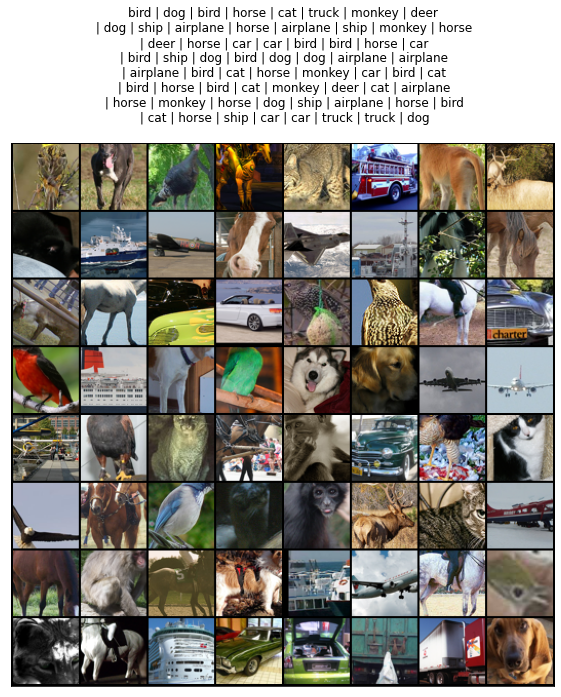

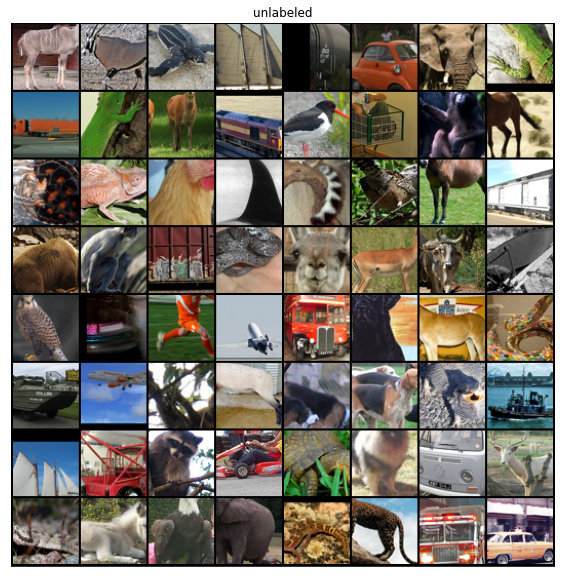

In [4]:
# Visualize the data within the dataset
class_names = dict(zip(range(10), dataset_tr.classes))
dataloader_un = DataLoader(dataset_un, batch_size=64)
dataloader_tr = DataLoader(dataset_tr, batch_size=64)

def imshow(inp, title=None, ax=None, figsize=(5, 5)):
  """Imshow for Tensor."""
  inp = inp.numpy().transpose((1, 2, 0))
  if ax is None:
    fig, ax = plt.subplots(1, figsize=figsize)
  ax.imshow(inp)
  ax.set_xticks([])
  ax.set_yticks([])
  if title is not None:
    ax.set_title(title)

# Visualize training partition
# Get a batch of training data
inputs, classes = next(iter(dataloader_tr))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=8)

fig, ax = plt.subplots(1, figsize=(10, 10))
title = [class_names[x.item()] if (i+1) % 8 != 0 else class_names[x.item()]+'\n' for i, x in enumerate(classes)]
imshow(out, title=' | '.join(title), ax=ax)

# Visualize unlabeled partition
inputs, classes = next(iter(dataloader_un))
out = torchvision.utils.make_grid(inputs, nrow=8)

fig, ax = plt.subplots(1, figsize=(10, 10))
imshow(out, title='unlabeled', ax=ax)

As can be seen from above visualizations, the unlabeled partition contains classes that are not in the training partition. Though not labeled, the unlabeled partition has much more data than the labeled training partition. The large amount of unlabeled label ought to help us learn useful representations. In the next sections, we will use the unlabeled partition to help learn representations that is helpful for downstream tasks.

# Part 1. Autoencoders

We will first build an autoencoder. To keep training time low, we'll use a very simple network structure.

## 1.1 Build the encoder
Please make sure that your encoder has the same architeture as we print below before your proceed to the decoder part.

### Encoder archiecture

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #  
            Conv2d-1           [-1, 12, 32, 32]             588  
              ReLU-2           [-1, 12, 32, 32]               0  
            Conv2d-3           [-1, 24, 16, 16]           4,632  
              ReLU-4           [-1, 24, 16, 16]               0  
            Conv2d-5             [-1, 48, 8, 8]          18,480  
              ReLU-6             [-1, 48, 8, 8]               0   
            Conv2d-7             [-1, 24, 4, 4]          18,456  
              ReLU-8             [-1, 24, 4, 4]               0  
Total params: 42,156  
Trainable params: 42,156  
Non-trainable params: 0  
Input size (MB): 0.05
Forward/backward pass size (MB): 0.33  
Params size (MB): 0.16  
Estimated Total Size (MB): 0.54  

In [0]:
class Encoder(nn.Module):
    def __init__(self, in_channels=3):
        super(Encoder, self).__init__()

        ##############################################################################
        # TODO: Build an encoder with the architecture as specified above.           #
        ##############################################################################
        self.encoder = nn.Sequential(
          nn.Conv2d(in_channels, 12, kernel_size=4,stride=2, padding=1),
          nn.ReLU(True),
          
          nn.Conv2d(12, 24, kernel_size=4, stride=2,padding=1),
          nn.ReLU(True),

          nn.Conv2d(24, 48, kernel_size=4, stride=2, padding=1),
          nn.ReLU(True),

          nn.Conv2d(48, 24, kernel_size=4, stride =2, padding=1),
          nn.ReLU(True))
        ##############################################################################
        #                               END OF YOUR CODE                             #
        ##############################################################################

    def forward(self, x):
        '''
        Given an image x, return the encoded latent representation h.

        Args:
            x: torch.tensor

        Return: 
            h: torch.tensor
        '''
        
        h = self.encoder(x)

        return h

In [6]:
# Print out the neural network architectures and activation dimensions.
# Verify that your network has the same architecture as the one we printed above.
encoder = Encoder().to(device)
summary(encoder, [(3, 64, 64)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 32, 32]             588
              ReLU-2           [-1, 12, 32, 32]               0
            Conv2d-3           [-1, 24, 16, 16]           4,632
              ReLU-4           [-1, 24, 16, 16]               0
            Conv2d-5             [-1, 48, 8, 8]          18,480
              ReLU-6             [-1, 48, 8, 8]               0
            Conv2d-7             [-1, 24, 4, 4]          18,456
              ReLU-8             [-1, 24, 4, 4]               0
Total params: 42,156
Trainable params: 42,156
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 0.33
Params size (MB): 0.16
Estimated Total Size (MB): 0.54
----------------------------------------------------------------


## 1.2 Build the decoder

Next, we build the decoder to reconstruct the image from the latent representation extracted by the encoder. Please implement the decoder following the architectrue printed here. 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #  
              ConvTranspose2d-1   [-1, 48, 8, 8]         18,480  
              ReLU-2              [-1, 48, 8, 8]              0  
              ConvTranspose2d-3   [-1, 24, 16, 16]       18,456  
              ReLU-4              [-1, 24, 16, 16]            0
              ConvTranspose2d-5   [-1, 12, 32, 32]        4,620  
              ReLU-6              [-1, 12, 32, 32]            0  
              ConvTranspose2d-7   [-1, 3, 64, 64]           579  
              Sigmoid-8           [-1, 3, 64, 64]             0  

Total params: 42,135  
Trainable params: 42,135  
Non-trainable params: 0  
Input size (MB): 0.00  
Forward/backward pass size (MB): 0.52  
Params size (MB): 0.16  
Estimated Total Size (MB): 0.68  

In [0]:
class Decoder(nn.Module):
    def __init__(self, out_channels=3, feat_dim=64):
        super(Decoder, self).__init__()

        ##############################################################################
        # TODO: Build the decoder as specified above.                                #
        ##############################################################################
        self.decoder = nn.Sequential(
          nn.ConvTranspose2d(24, 48, kernel_size=4,stride=2, padding=1),
          nn.ReLU(True),
          
          nn.ConvTranspose2d(48, 24, kernel_size=4, stride=2,padding=1),
          nn.ReLU(True),

          nn.ConvTranspose2d(24, 12, kernel_size=4, stride=2, padding=1),
          nn.ReLU(True),

          nn.ConvTranspose2d(12, out_channels, kernel_size=4, stride =2, padding=1),
          nn.Sigmoid())

        ##############################################################################
        #                               END OF YOUR CODE                             #
        ##############################################################################

    def forward(self, h):
        '''
        Given latent representation h, reconstruct an image patch of size 64 x 64.

        Args:
            h: torch.tensor

        Return: 
            x: torch.tensor
        '''
        x = self.decoder(h)
        return x

In [8]:
# Print out the neural network architectures and activation dimensions.
# Verify that your network has the same architecture as the one we printed above.
decoder = Decoder().to(device)
summary(decoder, [(24, 4, 4)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1             [-1, 48, 8, 8]          18,480
              ReLU-2             [-1, 48, 8, 8]               0
   ConvTranspose2d-3           [-1, 24, 16, 16]          18,456
              ReLU-4           [-1, 24, 16, 16]               0
   ConvTranspose2d-5           [-1, 12, 32, 32]           4,620
              ReLU-6           [-1, 12, 32, 32]               0
   ConvTranspose2d-7            [-1, 3, 64, 64]             579
           Sigmoid-8            [-1, 3, 64, 64]               0
Total params: 42,135
Trainable params: 42,135
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.52
Params size (MB): 0.16
Estimated Total Size (MB): 0.68
----------------------------------------------------------------


## 1.3 Put together the autoencoder

Now we have the encoder and the decoder classes. We only need to implement another `Autoencoder` class to wrap the encoder and the decoder together.

In [0]:
class Autoencoder(nn.Module):
    def __init__(self, in_channels=3, feat_dim=64):
        super(Autoencoder, self).__init__()

        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        '''
        Compress and reconstruct the input image with encoder and decoder.

        Args:
            x: torch.tensor

        Return: 
            x_: torch.tensor
        '''

        h = self.encoder(x)
        x_ = self.decoder(h)

        return x_

In [10]:
# verify that your aueconder's output size is 3 x 64 x 64 
ae = Autoencoder().to(device)
summary(ae, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 32, 32]             588
              ReLU-2           [-1, 12, 32, 32]               0
            Conv2d-3           [-1, 24, 16, 16]           4,632
              ReLU-4           [-1, 24, 16, 16]               0
            Conv2d-5             [-1, 48, 8, 8]          18,480
              ReLU-6             [-1, 48, 8, 8]               0
            Conv2d-7             [-1, 24, 4, 4]          18,456
              ReLU-8             [-1, 24, 4, 4]               0
           Encoder-9             [-1, 24, 4, 4]               0
  ConvTranspose2d-10             [-1, 48, 8, 8]          18,480
             ReLU-11             [-1, 48, 8, 8]               0
  ConvTranspose2d-12           [-1, 24, 16, 16]          18,456
             ReLU-13           [-1, 24, 16, 16]               0
  ConvTranspose2d-14           [-1, 12,

## 1.4 Training the autoencoder

Now, we'll train the autoencoder to reconstruct images from the unlabeled set of STL-10. Note that the reconstructed images will contain significant artifacts, due to the limited size of the bottleneck between the encoder and decoder, and the small network size.

In [0]:
# We train on 10,000 unsupervised sampels instead of 100,000 samples to speed up training
n = 10000
dataset_un_subset, _ = torch.utils.data.random_split(dataset_un, [n,100000-n])
dataloader_un = DataLoader(dataset_un_subset, batch_size=128, shuffle=True)
dataloader_tr = DataLoader(dataset_tr, batch_size=128, shuffle=True)
dataloader_te = DataLoader(dataset_te, batch_size=128, shuffle=False)

In [0]:
def visualize_recon(model, dataloader):
    '''
    Helper function for visualizing reconstruction performance.

    Randomly sample 8 images and plot the original/reconstructed images. 
    '''
    model.eval()
    img = next(iter(dataloader))[0][:8].to(device)
    out = model(img)

    fig, ax = plt.subplots(1, 1, figsize=(15,10))
    inp = torchvision.utils.make_grid(torch.cat((img, out), dim=2), nrow=8)
    imshow(inp.detach().cpu(), ax=ax)
    model.train()
    plt.show()

In [0]:
def train_ae(model, dataloader, epochs=200):
    '''
    Train autoencoder model.

    Args:
        model: torch.nn.module.
        dataloader: DataLoader. The unlabeled partition of the STL dataset.
    '''

    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()
    loss_traj = []

    for epoch in tqdm_notebook(range(epochs)):

        loss_epoch = 0
        for x, _ in dataloader:

            ##############################################################################
            # TODO: Train the autoencoder on one minibatch.                              #
            ##############################################################################
            x= x.cuda()
            
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, x)
            loss.backward()
            optimizer.step()

            ##############################################################################
            #                               END OF YOUR CODE                             #
            ##############################################################################
            loss_epoch += loss.detach()

        loss_traj.append(loss_epoch)
        
        if epoch % 10 == 0:
            print('Epoch {}, loss {:.3f}'.format(epoch, loss_epoch))
            visualize_recon(model, dataloader)

    return model, loss_traj

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Epoch 0, loss 4.063


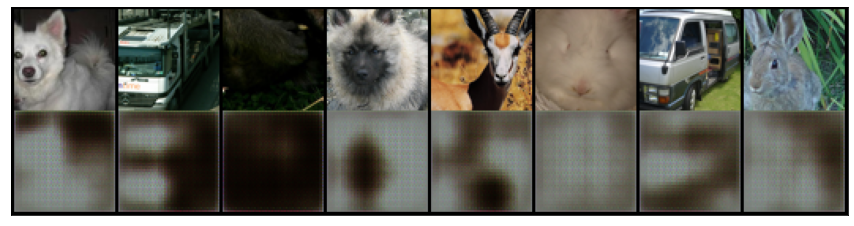

Epoch 10, loss 1.205


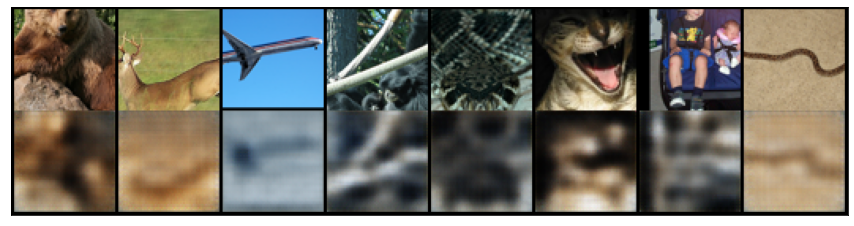

Epoch 20, loss 0.949


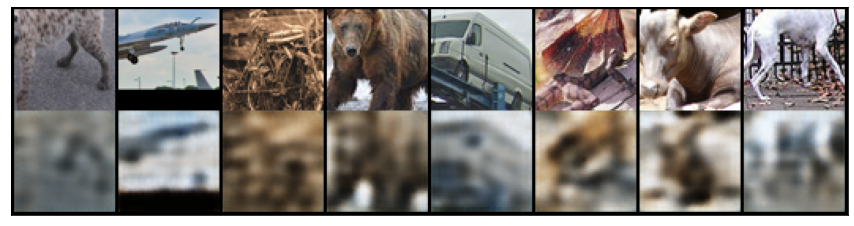

Epoch 30, loss 0.840


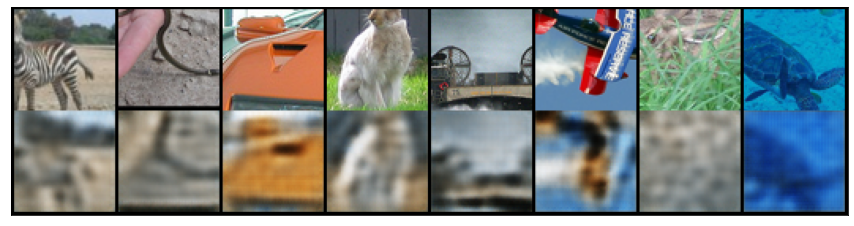

Epoch 40, loss 0.761


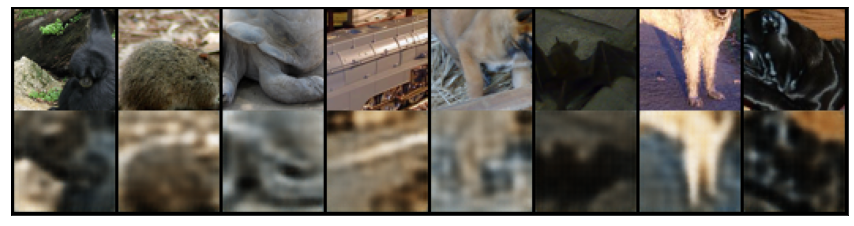

Epoch 50, loss 0.701


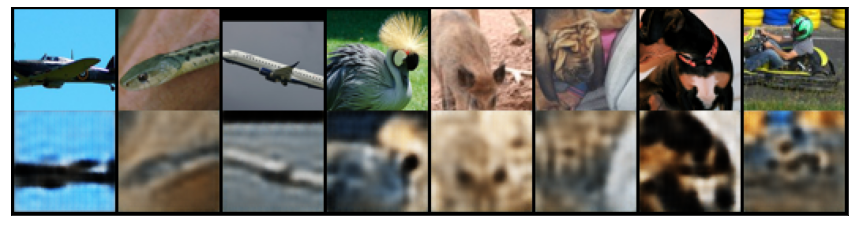

Epoch 60, loss 0.679


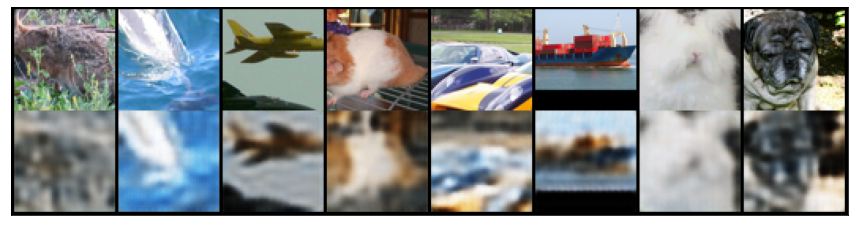

Epoch 70, loss 0.654


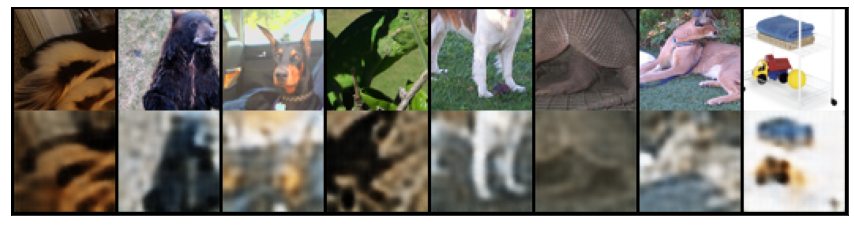

Epoch 80, loss 0.651


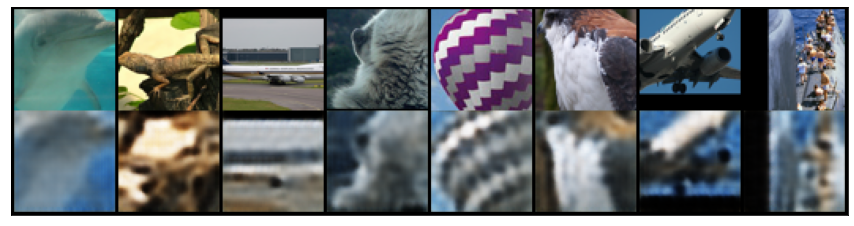

Epoch 90, loss 0.638


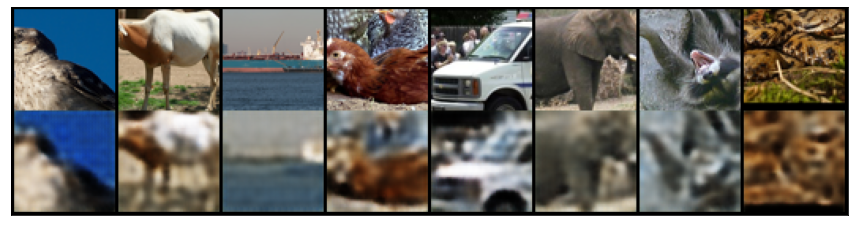

In [14]:
# Train the autoencoder for 100 epochs
ae = Autoencoder().to(device)
ae, ae_loss_traj = train_ae(ae, dataloader_un, epochs=100)
torch.save(ae.state_dict(), 'ae.pth')

After training the autoencoder on the 100,000 images for 100 epochs, we see that autoencoder has leanred to approximately recontruct the image.

## 1.5 Train a linear classifier

Now, we ask how useful the features are for object recongition. We'll train a linear clasifier that takes the output of the encoder as its features. During training, we freeze the parameters of the encoder. To verify the effectiveness of unsupervised pretraining, we compare the linear classifier accuracy against two baselines:

* Supervised: train the encoder together with the linear classifier on the training set for 100 epochs. 
* Random weights: freeze the parameters of a randomly initialized encoder during training. 

In [0]:
# latent representation dimension (the output dimension of the encoder)
feat_dim = 24 * 4 * 4

In [0]:
def train_classfier(encoder, cls, dataloader, epochs=100, supervised=False):
    '''
    Args:
        encoder: trained/untrained encoder for unsupervised/supervised training.
        cls: linear classifier.
        dataloader: train partition.
        supervised: 

    Return:
        cls: linear classifier.
    '''

    optimizer = optim.Adam(cls.parameters(), lr=0.001, weight_decay=1e-4)
    if supervised:
        optimizer = optim.Adam(list(cls.parameters())+list(encoder.parameters()), lr=0.001, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()
    loss_traj = []
    accuracy_traj = []

    for epoch in tqdm_notebook(range(epochs)):

        loss_epoch = 0
        corrects_epoch = 0
        for x, y in dataloader:

            batch_size = x.size(0)
            x = x.float()
            ##############################################################################
            # TODO: update the parameters of the classifer. If in supervised mode, the   #
            # parameter of the encoder is also updated.                                  #
            ##############################################################################
            x= x.cuda()
            y= y.cuda()

            optimizer.zero_grad()

            output=encoder(x)
            output1 = output.view(batch_size,-1)

            outs = cls(output1)

            loss= criterion(outs,y)
            
            loss.backward()

            optimizer.step()
            

            ##############################################################################
            #                               END OF YOUR CODE                             #
            ##############################################################################
            _, preds = torch.max(outs, 1)
            corrects_epoch += torch.sum(preds == y.data)
            loss_epoch += loss.detach()

        loss_traj.append(loss_epoch)
        epoch_acc = corrects_epoch.double() / len(dataloader.dataset)
        accuracy_traj.append(epoch_acc)
    
        if epoch % 10 == 0:
            print('Epoch {}, loss {:.3f}, train accuracy {}'.format(epoch, loss_epoch, epoch_acc))

    return cls, loss_traj

In [0]:
def test(encoder, cls, dataloader):
    '''
    Calculate the accuracy of the trained linear classifier on the test set.
    '''
    cls.eval()

    loss_epoch = 0
    corrects_epoch = 0
    for x, y in dataloader:
        
        x = x.float()
        batch_size = x.size(0)
        x, y = x.to(device), y.to(device)
        h = encoder(x).view(batch_size, -1)
        outs = cls(h)
        _, preds = torch.max(outs, 1)
        corrects_epoch += torch.sum(preds == y.data)

    epoch_acc = corrects_epoch.double() / len(dataloader.dataset)
    print('Test accuracy {}'.format(epoch_acc))

In [18]:
# Method I: unsupervised pretraining + training linear classifier
# Freeze the parameters of the trained autoencoder
# Train a linear classifier using the features 
linear_cls = nn.Sequential(nn.Linear(feat_dim, 10)).to(device)
cls_unsupervised, loss_traj_unsupervised = train_classfier(ae.encoder, linear_cls, dataloader_tr, epochs=100)
test(ae.encoder, cls_unsupervised, dataloader_te)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Epoch 0, loss 95.798, train accuracy 0.1558
Epoch 10, loss 77.868, train accuracy 0.3146
Epoch 20, loss 75.351, train accuracy 0.3366
Epoch 30, loss 72.980, train accuracy 0.367
Epoch 40, loss 72.449, train accuracy 0.3634
Epoch 50, loss 70.994, train accuracy 0.3794
Epoch 60, loss 71.268, train accuracy 0.3864
Epoch 70, loss 69.357, train accuracy 0.4012
Epoch 80, loss 68.953, train accuracy 0.4086
Epoch 90, loss 68.005, train accuracy 0.4082

Test accuracy 0.286375


In [19]:
# Method II: supervised training
# Train the encoder together with the linear classifier
linear_cls = nn.Sequential(nn.Linear(feat_dim, 10)).to(device)
encoder = Autoencoder().to(device).encoder
cls_supervised, loss_traj_supervised = train_classfier(encoder, linear_cls, dataloader_tr, epochs=100, supervised=True)
test(encoder, cls_supervised, dataloader_te)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Epoch 0, loss 89.885, train accuracy 0.1458
Epoch 10, loss 57.429, train accuracy 0.4776
Epoch 20, loss 47.915, train accuracy 0.5640000000000001
Epoch 30, loss 39.120, train accuracy 0.6436000000000001
Epoch 40, loss 31.985, train accuracy 0.7190000000000001
Epoch 50, loss 24.014, train accuracy 0.7958000000000001
Epoch 60, loss 15.344, train accuracy 0.869
Epoch 70, loss 5.836, train accuracy 0.9664
Epoch 80, loss 2.320, train accuracy 0.9924000000000001
Epoch 90, loss 13.479, train accuracy 0.8858

Test accuracy 0.445375


In [20]:
# Method III: random encoder + training linear classifier
# We freeze the parameters of the randomly initialized encoder during training
linear_cls = nn.Sequential(nn.Linear(feat_dim, 10)).to(device)
encoder = Autoencoder().to(device).encoder
cls_random, loss_traj_random = train_classfier(encoder, linear_cls, dataloader_tr, epochs=100, supervised=False)
test(encoder, cls_random, dataloader_te)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Epoch 0, loss 92.114, train accuracy 0.096
Epoch 10, loss 91.423, train accuracy 0.21100000000000002
Epoch 20, loss 90.875, train accuracy 0.2056
Epoch 30, loss 90.429, train accuracy 0.2452
Epoch 40, loss 90.024, train accuracy 0.2556
Epoch 50, loss 89.638, train accuracy 0.2534
Epoch 60, loss 89.295, train accuracy 0.24860000000000002
Epoch 70, loss 89.039, train accuracy 0.25020000000000003
Epoch 80, loss 88.800, train accuracy 0.2682
Epoch 90, loss 88.588, train accuracy 0.2674

Test accuracy 0.263375


With pretrained encoder, the linear classifier should achieve about 30% accuracy on the test set. With the supervised approach, the linear classifier should achieve an accuracy above 40%. The random encoder approach performs the worst among these three. The observation that the pretrained encoder outperforms the random encoder confirms that unsupervised pretraining has learnt a useful represenation. However, the quality of this learned representation is not good because it only performs slightly better than the random encoder. In the next part, we'll explore contrastive multiview coding, which learns a more useful representation than the autoencoder.

In [0]:
del dataset_un
del dataset_te
del dataset_tr

# Part 2. Contrastive Multiview Coding




In this part, we will implement contrastive multi-view coding (CMC). This is a variation of the contrastive representation learning method we discussed in class. We'll learn a vector representation for images: in this representation, two artificially corrupted versions of a given image should have a large dot product, while dot products of two different images should have a small dot product.
In contrastive multiview coding, these corruptions are  "views" of an image that contain complementary information (e.g. color and grayscale values). A good representation should create similar vectors for these two views. The contrastive learning objective can be expressed as:
$$
\mathcal{L}_{\text {contrast }}^{V_{1}, V_{2}}=-\operatorname{E}_{\left\{v_{1}^{1}, v_{2}^{1}, \ldots, v_{2}^{k+1}\right\}}\left[\log \frac{h_{\theta}(v_{1}^{1}, v_{2}^{1})}{\sum_{j=1}^{k+1} h_{\theta}(v_{1}^{1}, v_{2}^{j})}\right],
$$
where $v_1$ and $v_2$ are the two views, and $k$ is the number of negative samples (i.e. views from other examples that do not correspond to $v_1$). We implement $h_\theta$ with a neural network:
$$
h_{\theta}\left(\left\{v_{1}, v_{2}\right\}\right)=\exp \left(\frac{f_{\theta_{1}}\left(v_{1}\right) \cdot f_{\theta_{2}}\left(v_{2}\right)}{\left\|f_{\theta_{1}}\left(v_{1}\right)\right\| \cdot\left\|f_{\theta_{2}}\left(v_{2}\right)\right\|} \cdot \frac{1}{\tau}\right),
$$
where $f_{\theta_1}$ and $f_{\theta_2}$ are encoders for extracting representations from view 1 and view 2, respectively, and $\tau$ is the temperature hyperparameter for controlling the range of the exponential score. 

We'll make the loss treat the two views the same by adding two versions of the loss together: $\mathcal{L}_{\text {contrast }}^{V_{1}, V_{2}}$ and $\mathcal{L}_{\text {contrast }}^{V_{2}, V_{1}}$, i.e.,
$$
\mathcal{L}\left(V_{1}, V_{2}\right)=\mathcal{L}_{\text {contrast }}^{V_{1}, V_{2}}+\mathcal{L}_{\text {contrast }}^{V_{2}, V_{1}}.
$$

We will implement CMC on $Lab$ image color space. Like the familiar RGB color space, Lab iamges have three channels. Channel $L$ corresponds to the _luminance_ of the image and channels $ab$ corresponds to the _chrominance_ of the image. During contrastive training, $L$ channel and $ab$ channels will be processed by two encoders separately.

In [0]:
# color space transfrom
from skimage import color

class RGB2Lab(object):
    """Convert RGB PIL image to ndarray Lab."""
    def __call__(self, img):
        img = np.asarray(img, np.uint8)
        img = color.rgb2lab(img)
        return img

Lab color image size (64, 64, 3)


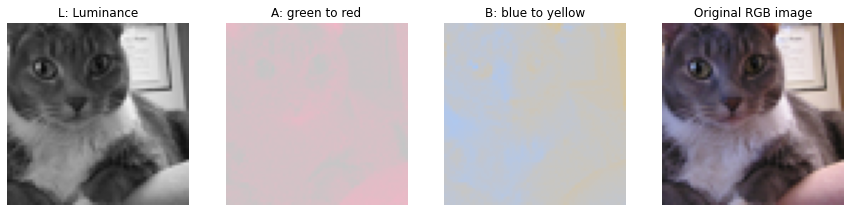

In [23]:
# Visualize the Lab color channels. 

original = dataloader_te.dataset[4][0].numpy().transpose((1,2,0))
lab = color.rgb2lab(original)
print('Lab color image size {}'.format(lab.shape))

def extract_single_dim_from_LAB_convert_to_RGB(image,idim):
    '''
    image is a single lab image of shape (None,None,3)
    '''
    z = np.zeros(image.shape)
    if idim != 0 :
        z[:,:,0]=80 ## need brightness to plot the image along 1st or 2nd axis
    z[:,:,idim] = image[:,:,idim]
    z = color.lab2rgb(z)
    return(z)

fig, ax = plt.subplots(1, 4, figsize=(15,10))
lab_rgb_gray = extract_single_dim_from_LAB_convert_to_RGB(lab,0) 
ax[0].imshow(lab_rgb_gray); ax[0].axis("off")
ax[0].set_title("L: Luminance")

lab_rgb_gray = extract_single_dim_from_LAB_convert_to_RGB(lab,1) 
ax[1].imshow(lab_rgb_gray); ax[1].axis("off")
ax[1].set_title("A: green to red")

lab_rgb_gray = extract_single_dim_from_LAB_convert_to_RGB(lab,2) 
ax[2].imshow(lab_rgb_gray); ax[2].axis("off")
ax[2].set_title("B: blue to yellow")

ax[3].imshow(original); ax[3].axis("off")
ax[3].set_title("Original RGB image")
plt.show()

Modify the \_\_getitem\_\_ method of PyTorch STL-10 Dataset class so that it returns the index of the returned image. The index will be used later in the contrastive learning to form positive/negative training pairs.

In [0]:
# This part can be ignored.

from __future__ import print_function
from PIL import Image
import os
import os.path
import numpy as np

from torchvision.datasets.vision import VisionDataset
from torchvision.datasets.utils import check_integrity, download_and_extract_archive, verify_str_arg

class STL10_CMC(VisionDataset):
    """`STL10 <https://cs.stanford.edu/~acoates/stl10/>`_ Dataset.
    Args:
        root (string): Root directory of dataset where directory
            ``stl10_binary`` exists.
        split (string): One of {'train', 'test', 'unlabeled', 'train+unlabeled'}.
            Accordingly dataset is selected.
        folds (int, optional): One of {0-9} or None.
            For training, loads one of the 10 pre-defined folds of 1k samples for the
             standard evaluation procedure. If no value is passed, loads the 5k samples.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        download (bool, optional): If true, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.
    """
    base_folder = 'stl10_binary'
    url = "http://ai.stanford.edu/~acoates/stl10/stl10_binary.tar.gz"
    filename = "stl10_binary.tar.gz"
    tgz_md5 = '91f7769df0f17e558f3565bffb0c7dfb'
    class_names_file = 'class_names.txt'
    folds_list_file = 'fold_indices.txt'
    train_list = [
        ['train_X.bin', '918c2871b30a85fa023e0c44e0bee87f'],
        ['train_y.bin', '5a34089d4802c674881badbb80307741'],
        ['unlabeled_X.bin', '5242ba1fed5e4be9e1e742405eb56ca4']
    ]

    test_list = [
        ['test_X.bin', '7f263ba9f9e0b06b93213547f721ac82'],
        ['test_y.bin', '36f9794fa4beb8a2c72628de14fa638e']
    ]
    splits = ('train', 'train+unlabeled', 'unlabeled', 'test')

    def __init__(self, root, split='train', folds=None, transform=None,
                 target_transform=None, download=False):
        super(STL10_CMC, self).__init__(root, transform=transform,
                                    target_transform=target_transform)
        self.split = verify_str_arg(split, "split", self.splits)
        self.folds = self._verify_folds(folds)

        if download:
            self.download()
        elif not self._check_integrity():
            raise RuntimeError(
                'Dataset not found or corrupted. '
                'You can use download=True to download it')

        # now load the picked numpy arrays
        if self.split == 'train':
            self.data, self.labels = self.__loadfile(
                self.train_list[0][0], self.train_list[1][0])
            self.__load_folds(folds)

        elif self.split == 'train+unlabeled':
            self.data, self.labels = self.__loadfile(
                self.train_list[0][0], self.train_list[1][0])
            self.__load_folds(folds)
            unlabeled_data, _ = self.__loadfile(self.train_list[2][0])
            self.data = np.concatenate((self.data, unlabeled_data))
            self.labels = np.concatenate(
                (self.labels, np.asarray([-1] * unlabeled_data.shape[0])))

        elif self.split == 'unlabeled':
            self.data, _ = self.__loadfile(self.train_list[2][0])
            self.labels = np.asarray([-1] * self.data.shape[0])
        else:  # self.split == 'test':
            self.data, self.labels = self.__loadfile(
                self.test_list[0][0], self.test_list[1][0])

        class_file = os.path.join(
            self.root, self.base_folder, self.class_names_file)
        if os.path.isfile(class_file):
            with open(class_file) as f:
                self.classes = f.read().splitlines()

    def _verify_folds(self, folds):
        if folds is None:
            return folds
        elif isinstance(folds, int):
            if folds in range(10):
                return folds
            msg = ("Value for argument folds should be in the range [0, 10), "
                   "but got {}.")
            raise ValueError(msg.format(folds))
        else:
            msg = "Expected type None or int for argument folds, but got type {}."
            raise ValueError(msg.format(type(folds)))

    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        if self.labels is not None:
            img, target = self.data[index], int(self.labels[index])
        else:
            img, target = self.data[index], None

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(np.transpose(img, (1, 2, 0)))

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target, index

    def __len__(self):
        return self.data.shape[0]

    def __loadfile(self, data_file, labels_file=None):
        labels = None
        if labels_file:
            path_to_labels = os.path.join(
                self.root, self.base_folder, labels_file)
            with open(path_to_labels, 'rb') as f:
                labels = np.fromfile(f, dtype=np.uint8) - 1  # 0-based

        path_to_data = os.path.join(self.root, self.base_folder, data_file)
        with open(path_to_data, 'rb') as f:
            # read whole file in uint8 chunks
            everything = np.fromfile(f, dtype=np.uint8)
            images = np.reshape(everything, (-1, 3, 96, 96))
            images = np.transpose(images, (0, 1, 3, 2))

        return images, labels

    def _check_integrity(self):
        root = self.root
        for fentry in (self.train_list + self.test_list):
            filename, md5 = fentry[0], fentry[1]
            fpath = os.path.join(root, self.base_folder, filename)
            if not check_integrity(fpath, md5):
                return False
        return True

    def download(self):
        if self._check_integrity():
            print('Files already downloaded and verified')
            return
        download_and_extract_archive(self.url, self.root, filename=self.filename, md5=self.tgz_md5)
        self._check_integrity()

    def extra_repr(self):
        return "Split: {split}".format(**self.__dict__)

    def __load_folds(self, folds):
        # loads one of the folds if specified
        if folds is None:
            return
        path_to_folds = os.path.join(
            self.root, self.base_folder, self.folds_list_file)
        with open(path_to_folds, 'r') as f:
            str_idx = f.read().splitlines()[folds]
            list_idx = np.fromstring(str_idx, dtype=np.uint8, sep=' ')
            self.data, self.labels = self.data[list_idx, :, :, :], self.labels[list_idx]

In [25]:
# Add RGB2Lab color space transform to the dataloader.
color_transfer = RGB2Lab()
unlabeled_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                          transforms.RandomCrop(64),
                                          color_transfer,
                                          transforms.ToTensor()])

labeled_transform = transforms.Compose([transforms.CenterCrop(64),
                                        color_transfer,
                                        transforms.ToTensor()])


# We use the PyTorch built-in class to download the STL-10 dataset.
# The 'unlabeled' partition contains 100,000 images without labels.
# It's used for leanring representations with unsupervised learning. 
dataset_un = STL10_CMC('./data', 'unlabeled', download=True, transform=unlabeled_transform)

dataset_tr = torchvision.datasets.STL10('./data', 'train', download=False, transform=labeled_transform)
dataset_te = torchvision.datasets.STL10('./data', 'test', download=False, transform=labeled_transform)

Files already downloaded and verified


## 2.1 Build CMC Encoders

We use two encoders for CMC. One for extracting representations from L channel, another is used for extracting representations from ab channels. For a fair comparison, we use the same encoder architecture we built in Part 1.

In [0]:
class EncoderCMC(nn.Module):
    def __init__(self):
        super(EncoderCMC, self).__init__()

        self.l_encoder = Encoder(in_channels=1)
        self.ab_encoder = Encoder(in_channels=2)

    def forward(self, x):
        '''
        Extract features from L and ab channels.

        Args:
            x: torch.tensor

        Returns:
            feat_l: torch.tensor, (-1, feat_dim)
            feat_ab: torch.tensor, (-1, feat_dim)
        '''

        ##############################################################################
        # TODO: apply l_encoder and ab_encoder to the L channel and ab channels of   #
        # the input image x. You can first split x according to channels. Then apply #
        # l_encoder and ab_encoder independently to corresponding channels.          #
        ##############################################################################
        #l, ab = torch.split (x, [1, 2], dim = 1)
        #feat_l = self.l_encoder(l).reshape(-1, feat_dim)
        #feat_ab = self.ab_encoder(ab).reshape(-1, feat_dim)
        feat_l = self.l_encoder(x[:,:1,:,:]).view(-1, feat_dim)
        feat_ab = self.ab_encoder(x[:,1:,:,:]).view(-1, feat_dim)
        ##############################################################################
        #                               END OF YOUR CODE                             #
        ##############################################################################
        return feat_l, feat_ab

In [0]:
encoder_cmc = EncoderCMC().to(device)
img = torch.rand(128, 3, 64, 64).cuda()
feat_l, feat_ab = encoder_cmc(img)
assert feat_l.size() == (128, feat_dim), "L feature has wrong dimension"
assert feat_ab.size() == (128, feat_dim), "ab feature has wrong dimension"

## 2.2 Implement the CMC loss

As the first step, we compute the normalized dot product between the L features and ab features for postitive and negative pairs i.e., 
$$
\log{h_{\theta}\left(\left\{v_{1}, v_{2}\right\}\right)}=\frac{f_{\theta_{1}}\left(v_{1}\right) \cdot f_{\theta_{2}}\left(v_{2}\right)}{\left\|f_{\theta_{1}}\left(v_{1}\right)\right\| \cdot\left\|f_{\theta_{2}}\left(v_{2}\right)\right\|} \cdot \frac{1}{\tau}
$$

In [0]:
import math
class CMCScore(nn.Module):
    '''
    Calculate ℎ𝜃({𝑣1,𝑣2}) and ℎ𝜃({𝑣2,𝑣1}).

    To efficiently compute the scores, we use memories to store L and ab 
    representations. For more details on this, please refer to the original
    CMC paper
    '''

    def __init__(self, feat_dim, N, K, T=0.1, momentum=0.5):
        '''
        Args:
            feat_dim: int, dimension of the extracted representations
            N: int, number of samples in the dataset.
            K: int, number of negative examples.
            T: float, temperature.
            momentum: float. momentum of memory. 
        '''
        super(CMCScore, self).__init__()
        self.N = N
        self.K = K
        self.feat_dim = feat_dim
        self.ones = torch.ones(N).cuda()
        self.eps = 1e-7

        self.register_buffer('params', torch.tensor([K, T, momentum]))
        stdv = 1. / math.sqrt(feat_dim / 3)
        self.register_buffer('memory_l', torch.rand(N, feat_dim).mul_(2 * stdv).add_(-stdv))
        self.register_buffer('memory_ab', torch.rand(N, feat_dim).mul_(2 * stdv).add_(-stdv))

    def forward(self, l, ab, y, idx=None):
        '''
        Args:
            l: torch.tensor. l channel representation. (-1, feat_dim)
            ab: torch.tensor. ab channel representation. (-1, feat_dim)
            y: torch.tensor. Dataset index corresponding to the input images.
            
        Returns:
            out_l: torch.tensor. (-1, K+1, 1)
            out_ab: torch.tensor. (-1, K+1, 1)
        '''
        K = int(self.params[0].item())
        T = self.params[1].item()

        momentum = self.params[2].item()
        batch_size = l.size(0)
        N = self.N
        feat_dim = self.feat_dim

        # normalize l and ab representations
        l = l / (l.pow(2).sum(dim=1, keepdim=True).sqrt() + self.eps)
        ab = ab / (ab.pow(2).sum(dim=1, keepdim=True).sqrt() + self.eps)

        # Randomly sample K indicies for each anchor data to form negative pairs. 
        if idx is None:
            idx = torch.multinomial(self.ones, batch_size*(self.K+1), replacement=True)
            idx = idx.view(batch_size, -1)
            # set the 0-th element to be positive sample.
            idx.select(1, 0).copy_(y.data)

        ##############################################################################
        # TODO: compute out_l and out_ab. out_l is the normalized dot product between# 
        # anchor l channel and randomly sampled ab channels. out_ab is the opposite. #
        # Using the stored representations from the memory to avoid computing new    #
        # representations on-the-fly. Make sure you use the idx varaible we created  #
        # above to retrieve representations from the memory.                         #
        ##############################################################################
        
        weight_l_channel = torch.index_select(self.memory_l , 0 , idx.view(-1)).detach()
        weight_l_channel = weight_l_channel.view(batch_size, K + 1, -1)

        out_ab = torch.bmm(weight_l_channel , ab.view(batch_size, -1, 1))
        out_ab = torch.div(out_ab, T)

        weight_ab_channel = torch.index_select(self.memory_ab , 0, idx.view(-1)).detach()
        weight_ab_channel = weight_ab_channel.view(batch_size, K + 1, -1)

        out_l = torch.bmm(weight_ab_channel, l.view (batch_size, -1 , 1))
        out_l = torch.div(out_l, T)

        ##############################################################################
        #                               END OF YOUR CODE                             #
        ##############################################################################
        out_l = out_l.contiguous()
        out_ab = out_ab.contiguous()

        # # update memory
        with torch.no_grad():
            l_pos = torch.index_select(self.memory_l, 0, y.view(-1))
            l_pos.mul_(momentum)
            l_pos.add_(torch.mul(l, 1 - momentum))
            l_norm = l_pos.pow(2).sum(1, keepdim=True).pow(0.5)
            updated_l = l_pos.div(l_norm)
            self.memory_l.index_copy_(0, y, updated_l)

            ab_pos = torch.index_select(self.memory_ab, 0, y.view(-1))
            ab_pos.mul_(momentum)
            ab_pos.add_(torch.mul(ab, 1 - momentum))
            ab_norm = ab_pos.pow(2).sum(1, keepdim=True).pow(0.5)
            updated_ab = ab_pos.div(ab_norm)
            self.memory_ab.index_copy_(0, y, updated_ab)

        return out_l, out_ab

In [0]:
# sanity check
K = 256
contrast = CMCScore(feat_dim, 20000, K).cuda()
y = torch.randint(low=0, high=5000, size=(128,)).cuda()
out_l, out_ab = contrast(feat_l, feat_ab, y)
assert out_l.size() == (128, K+1, 1), "L scores have wrong dimension"
assert out_ab.size() == (128, K+1, 1), "ab scores have wrong dimension"

Next, we compute the softmax loss $\mathcal{L}_{\text {contrast }}^{V_{1}, V_{2}}$ and $\mathcal{L}_{\text {contrast }}^{V_{2}, V_{1}}$.



In [0]:
class SoftmaxLoss(nn.Module):
    """
    Softmax cross-entropy loss.
    """
    def __init__(self):
        super(SoftmaxLoss, self).__init__()
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):

        batch_size = x.shape[0]
        x = x.squeeze()

        ##############################################################################
        # TODO: compute loss values. Note that you need to provide label to          # 
        # CrossEntropyLoss. (Hint: the positive sample is always the first one).     #
        ##############################################################################
        label = torch.zeros(batch_size).cuda().long()
        loss = self.criterion(x, label)
        
        ##############################################################################
        #                               END OF YOUR CODE                             #
        ##############################################################################

        return loss

In [31]:
criterion_l = SoftmaxLoss().cuda()
criterion_ab = SoftmaxLoss().cuda()

# make sure the loss values are scalars
criterion_l(out_l), criterion_ab(out_ab)

(tensor(5.6822, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(5.7546, device='cuda:0', grad_fn=<NllLossBackward>))

## 2.3 Contrastive Multiview Training

Train L and ab encoders using the CMC loss fuction.

In [0]:
def train_cmc(model, contrast, criterion_l, criterion_ab, dataloader, epochs=100):

    optimizer = optim.Adam(model.parameters(), lr=1e-3, betas=(0.5, 0.999))

    for epoch in tqdm_notebook(range(epochs)):
    
        model.train()
        ab_prob_epoch = 0
        l_prob_epoch = 0
        loss_epoch = 0
        for idx, (inputs, _, index) in enumerate(dataloader):

            batch_size = inputs.size(0)
            inputs = inputs.float().to(device)
            index = index.to(device)

            ##############################################################################
            # TODO: compute loss values. Note that you need to provide label to          # 
            # CrossEntropyLoss. (Hint: the positive sample is always the first one).     #
            ##############################################################################
            optimizer.zero_grad()
            feat_l, feat_ab = model(inputs)
            out_l, out_ab = contrast(feat_l, feat_ab, index)
            l_loss = criterion_l(out_l)
            ab_loss = criterion_ab(out_ab)
            loss = l_loss + ab_loss
            loss.backward()
            optimizer.step()

            ##############################################################################
            #                               END OF YOUR CODE                             #
            ##############################################################################

            l_prob = F.softmax(out_l, dim=1)[:, 0, 0].sum().detach().cpu()
            ab_prob = F.softmax(out_ab, dim=1)[:, 0, 0].sum().detach().cpu()

            l_prob_epoch += l_prob
            ab_prob_epoch += ab_prob
            loss_epoch += loss.data

        l_prob_epoch = l_prob_epoch / len(dataloader.dataset)
        ab_prob_epoch = ab_prob_epoch / len(dataloader.dataset)
        loss_epoch = loss_epoch / len(dataloader)

        print('Epoch {}, loss {:.3f}\t' 
              'avg prob for L channel {:.3f}\t' 
              'avg prob for ab channels {:.3f}'.format(
                  epoch, loss_epoch, l_prob_epoch, ab_prob_epoch))

    return model

In [33]:
K = 256 # number of negative pairs
n = 10000
dataset_un_subset, _ = torch.utils.data.random_split(dataset_un, [n,100000-n])
dataloader_un_cmc = DataLoader(dataset_un_subset, batch_size=128, shuffle=True, num_workers=2)
contrast = CMCScore(feat_dim, 100000, K).cuda()

##############################################################################
#                        UNCOMMENT FOR DEBUGGING                             #
##############################################################################
# Uncomment these lines when debugging. It trains the CMC model on a subset of 
# STL-10 ublabeled. Make sure the loss value decreases and the average matching
# probablity increases over training.

#n = 2000
#dataset_debug, _ = torch.utils.data.random_split(dataset_un, [n,100000-n])
#dataloader_un_cmc = DataLoader(dataset_debug, batch_size=128, shuffle=True)

##############################################################################
#                        UNCOMMENT FOR DEBUGGING                             #
##############################################################################

# Training will take 30 mins.
encoder_cmc = EncoderCMC().to(device)
encoder_cmc = train_cmc(encoder_cmc, contrast, criterion_l, criterion_ab, dataloader_un_cmc, epochs=100)
torch.save(encoder_cmc.state_dict(), 'encoder_cmc.pth')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


Epoch 0, loss 11.352	avg prob for L channel 0.004	avg prob for ab channels 0.004
Epoch 1, loss 7.572	avg prob for L channel 0.036	avg prob for ab channels 0.041
Epoch 2, loss 6.663	avg prob for L channel 0.053	avg prob for ab channels 0.046
Epoch 3, loss 6.004	avg prob for L channel 0.072	avg prob for ab channels 0.056
Epoch 4, loss 6.006	avg prob for L channel 0.065	avg prob for ab channels 0.053
Epoch 5, loss 5.216	avg prob for L channel 0.096	avg prob for ab channels 0.092
Epoch 6, loss 5.746	avg prob for L channel 0.070	avg prob for ab channels 0.062
Epoch 7, loss 5.577	avg prob for L channel 0.075	avg prob for ab channels 0.073
Epoch 8, loss 5.566	avg prob for L channel 0.073	avg prob for ab channels 0.069
Epoch 9, loss 5.604	avg prob for L channel 0.069	avg prob for ab channels 0.072
Epoch 10, loss 5.750	avg prob for L channel 0.063	avg prob for ab channels 0.066
Epoch 11, loss 5.580	avg prob for L channel 0.067	avg prob for ab channels 0.075
Epoch 12, loss 5.438	avg prob for L c

## 2.4 Train a linear classifier

Train a linear classifier on top of the CMC representations.

In [0]:
class EncoderCMC_Cat(nn.Module):
    '''
    Wraper class for EncoderCMC. Concatenate feat_l and feat_ab to form a single 
    representation vector. This enables us to reuse the train_classifier routine.
    '''
    def __init__(self, model):
        super(EncoderCMC_Cat, self).__init__()
        self.model = model

    def forward(self, x):
        feat_l, feat_ab = self.model(x)
        return torch.cat((feat_l, feat_ab), dim=1)

In [0]:
dataloader_tr = DataLoader(dataset_tr, batch_size=128, shuffle=True, num_workers=2)
dataloader_te = DataLoader(dataset_te, batch_size=128, shuffle=False, num_workers=2)

In [36]:
encoder_cmc_cat = EncoderCMC_Cat(encoder_cmc)

linear_cls = nn.Sequential(nn.Linear(feat_dim*2, 10)).to(device)
cls_cmc, loss_traj_cmc = train_classfier(encoder_cmc_cat, linear_cls, dataloader_tr, epochs=100, supervised=False)
test(encoder_cmc_cat, cls_cmc, dataloader_te)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Epoch 0, loss 113.665, train accuracy 0.37320000000000003
Epoch 10, loss 42.692, train accuracy 0.6304000000000001
Epoch 20, loss 35.776, train accuracy 0.6688000000000001
Epoch 30, loss 32.053, train accuracy 0.7084
Epoch 40, loss 32.919, train accuracy 0.7086
Epoch 50, loss 28.811, train accuracy 0.7318
Epoch 60, loss 28.283, train accuracy 0.743
Epoch 70, loss 27.838, train accuracy 0.744
Epoch 80, loss 28.709, train accuracy 0.7432000000000001
Epoch 90, loss 26.294, train accuracy 0.764

Test accuracy 0.49512500000000004


# Report results

Please report the test accuracy of all four linear classifiers below.

### Autoencoder-based
method 1 accuracy: 0.286375 

method 2 accuracy: 0.445375

method 3 accuracy: 0.263375 

### CMC
accuracy: 0.49512500000000004


# Summary

So far, we have trained linear classifiers on top of autoencoder representations and CMC representations. 

With CMC, we learn a more useful representation than autoencoder. In the paper, the authors also implemented a more effective loss function based on Noise Contrastive Estimation (NCE). You are encouraged to implement NCE and compare its performance with our (K+1)-way Softmax loss function.